In [ ]:
from torchvision.datasets import VOCSegmentation
from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image
import torch
import numpy as np
from skimage.segmentation import mark_boundaries
import matplotlib.pylab as plt
from albumentations import HorizontalFlip, Compose, Resize, Normalize
from tqdm import tqdm
import os
import time
import cv2
import json

%matplotlib inline

In [ ]:
# VOCSegmentation dataset을 정의합니다.
class myVOCSegmentation(VOCSegmentation):
    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        target = Image.open(self.masks[index])

        if self.transforms is not None:
            augmented = self.transforms(image=np.array(img), mask=np.array(target))
            img = augmented['image']
            target = augmented['mask']
            target[target>20] = 0
        
        img = to_tensor(img)
        target = torch.from_numpy(target).type(torch.long)
        return img, target

In [ ]:
# transformation을 정의합니다.
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
h,w = 520, 520

transform_tran = Compose([Resize(h,w),
                          HorizontalFlip(p=0.5),
                          Normalize(mean=mean, std=std)])

transform_val = Compose([Resize(h,w),
                         Normalize(mean=mean, std=std)
                        ])

In [ ]:
# 데이터셋을 저장할 폴더를 생성합니다.
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print('Error')

createFolder('./data')

In [ ]:
# myVOCSegmentation dataset을 불러옵니다
path2data = './data'
train_ds = myVOCSegmentation(path2data, year='2012', image_set='train', download=True, transforms=transform_tran)
val_ds = myVOCSegmentation(path2data, year='2012', image_set='val', download=True, transforms=transform_val)

print(len(train_ds))
print(len(val_ds))

In [ ]:
# 샘플 이미지를 확인합니다.
np.random.seed(0)
num_classes = 21
COLORS = np.random.randint(0, 2, size=(num_classes+1,3), dtype='uint8')

# 이미지와 마스크를 함께 시각화하는 함수를 정의합니다.
def show_img_target(img, target):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        target=target.numpy()
    for ll in range(num_classes):
        mask=(target==ll)
        img=mark_boundaries(np.array(img),mask,outline_color=COLORS[ll],color=COLORS[ll])
    plt.imshow(img)

In [ ]:
# re-normalize 함수를 정의합니다.
def re_normalize(x, mean=mean, std=std):
    x_r = x.clone()
    for c, (mean_c, std_c) in enumerate(zip(mean,std)):
        x_r[c] *= std_c
        x_r[c] += mean_c
    return x_r

In [ ]:
# 샘플 이미지를 얻습니다.
img, mask = train_ds[25]
print(img.shape, img.type(), torch.max(img))
print(mask.shape, mask.type(), torch.max(mask))

In [ ]:
# 샘플 이미지를 시각화합니다.
plt.figure(figsize=(20,20))

img_r = re_normalize(img)
plt.subplot(1,3,1)
plt.imshow(to_pil_image(img_r))

plt.subplot(1,3,2)
plt.imshow(mask)

plt.subplot(1,3,3)
show_img_target(img_r, mask)

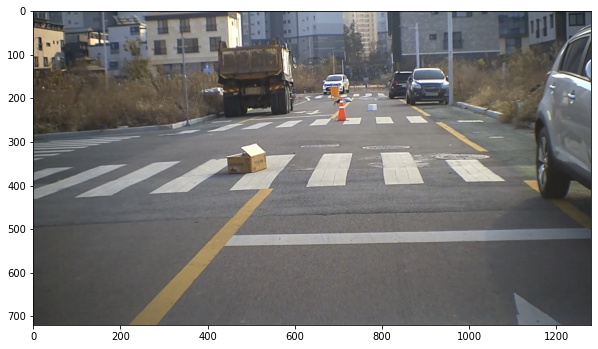

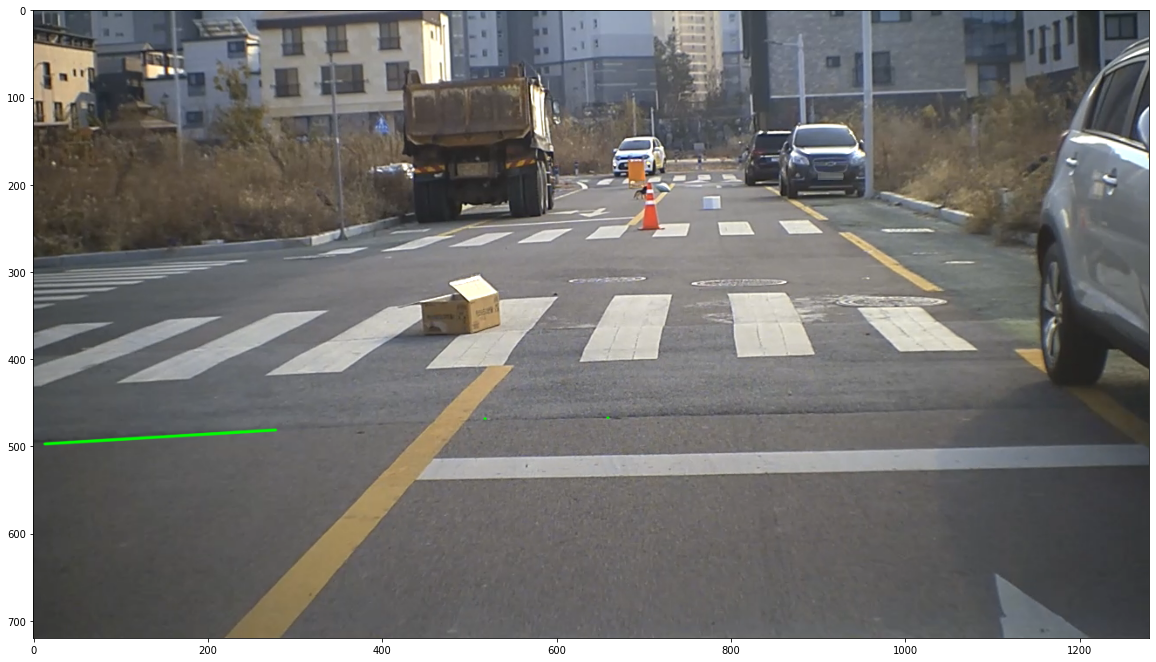

In [72]:
image = cv2.imread('/media/joo/Ultra Touch/V3F_HY_4650_20201221_141938_E_CH1_busan_Sun_Mainroad_Day_47524.png')
img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

with open("/media/joo/Ultra Touch/V3F_HY_4650_20201221_141938_E_CH1_busan_Sun_Mainroad_Day_47524_PLINE.json", "r") as f:
    js = json.load(f)

basket = list(map(lambda x : x , js['annotations']))
imageLine = img.copy()

f_dot = 0
s_dot = 2

for i, dt in enumerate(basket):
    tmp = list(map(lambda x : x, dt['polyline'][0]))
    for ii, j in enumerate(range(int(len(tmp)/4))):
        # print(ii,"어서그러ㅏㅁ?")
        cv2.line(imageLine, (round(tmp[f_dot]),round(tmp[f_dot+1])), (round(tmp[s_dot]),round(tmp[s_dot+1])), (0,255,0), thickness=2, lineType=cv2.LINE_AA)        
        f_dot += 2
        s_dot += 2
    f_dot = 0
    s_dot = 0
    # break

plt.figure(figsize=(10,10))

plt.imshow(img)
plt.show()
plt.close() 

plt.figure(figsize=(20,20))
plt.imshow(imageLine)
plt.show()
plt.close()